In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from qiskit import ClassicalRegister, QuantumRegister
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import Statevector
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit_machine_learning.neural_networks import SamplerQNN

import tensorflow as tf
import cv2

from math import sqrt, log2

algorithm_globals.random_seed = 42

/var/folders/38/kddld1k955775hyf55xdjbm40000gn/T/ipykernel_48655/3972327533.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


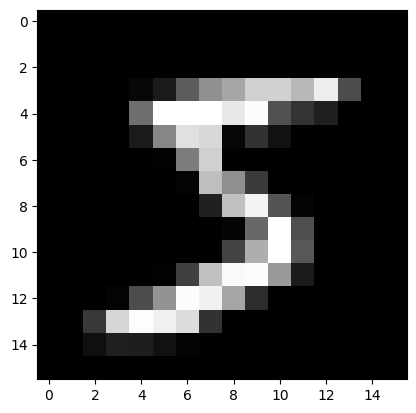

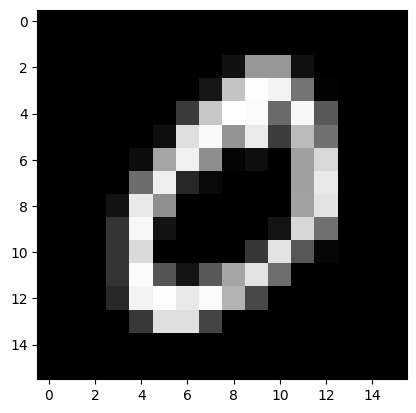

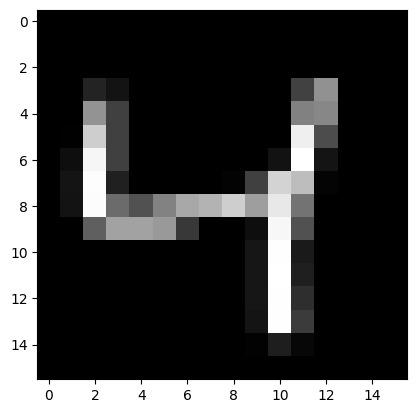

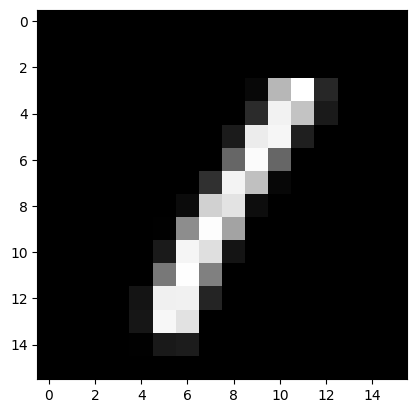

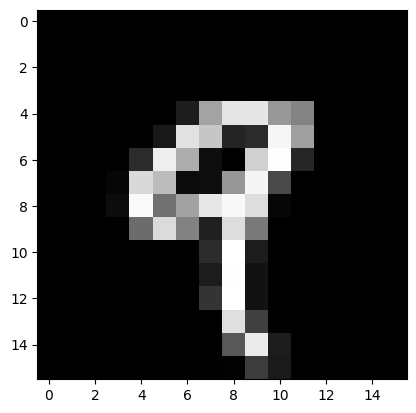

Resized train images shape: (500, 256)
Labels shape: 500


In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

one_dim = 256
new_size = (int(sqrt(one_dim)), int(sqrt(one_dim)))

# Resize images to 32x32 using OpenCV
resized_train_images = []
for img in train_images:
    resized_img = cv2.resize(img, new_size)
    resized_train_images.append(resized_img)

resized_test_images = []
for img in test_images:
    resized_img = cv2.resize(img, new_size)
    resized_test_images.append(resized_img)

# Convert lists to NumPy arrays
resized_train_images = np.array(resized_train_images)
resized_test_images = np.array(resized_test_images)

# Normalize the images
resized_train_images = resized_train_images / 255.0
resized_test_images = resized_test_images / 255.0

# print the first 5 images
for i in range(5):
    plt.imshow(resized_train_images[i], cmap = "gray")
    plt.show()

# Reshape images to 2D arrays
resized_train_images = resized_train_images.reshape(resized_train_images.shape[0], -1)
resized_test_images = resized_test_images.reshape(resized_test_images.shape[0], -1)

num_of_images = 50
num_of_digits = 10
new_images = [[] for _ in range(num_of_digits)]
new_labels = [[] for _ in range(num_of_digits)]
i = 0
while not all(len(lst) == num_of_images for lst in new_images):
    if train_labels[i] < num_of_digits and len(new_images[train_labels[i]]) < num_of_images:
        new_images[train_labels[i]].append(resized_train_images[i])
        new_labels[train_labels[i]].append(train_labels[i])
    i+=1

new_images = np.array(new_images)
new_images = new_images.reshape(new_images.shape[0] * new_images.shape[1], -1)
new_labels = np.array(new_labels)
new_labels = new_labels.reshape(new_labels.shape[0] * new_labels.shape[1], -1)

# Verify the new dimensions
print("Resized train images shape:", new_images.shape)
print("Labels shape:", len(new_labels))

In [4]:
def ansatz(num_qubits):
    return RealAmplitudes(num_qubits, reps=5)

In [5]:
def auto_encoder_circuit(num_latent, num_trash):
    qr = QuantumRegister(num_latent + 2 * num_trash + 1, "q")
    cr = ClassicalRegister(1, "c")
    circuit = QuantumCircuit(qr, cr)
    ansatz_circuit = ansatz(num_latent + num_trash)
    display(ansatz_circuit.decompose().draw(output="mpl", style="clifford"))
    circuit.compose(ansatz_circuit, range(0, num_latent + num_trash), inplace=True)
    circuit.barrier()
    auxiliary_qubit = num_latent + 2 * num_trash
    # swap test
    circuit.h(auxiliary_qubit)
    for i in range(num_trash):
        circuit.cswap(auxiliary_qubit, num_latent + i, num_latent + num_trash + i)

    circuit.h(auxiliary_qubit)
    circuit.measure(auxiliary_qubit, cr[0])
    return circuit

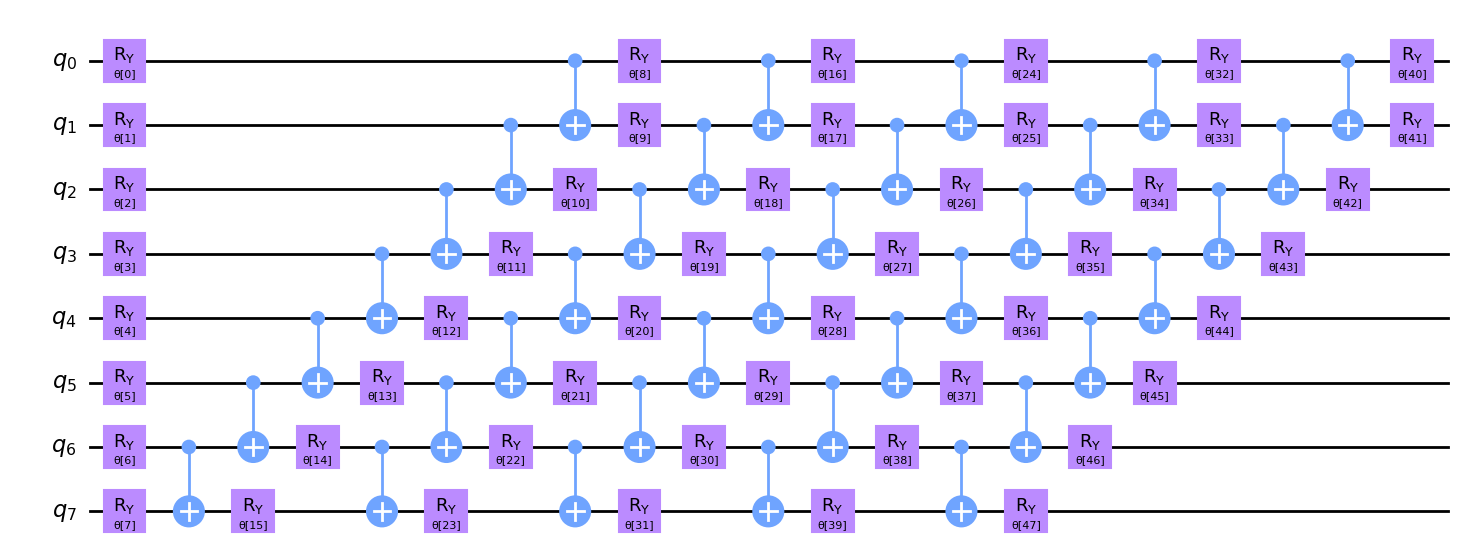

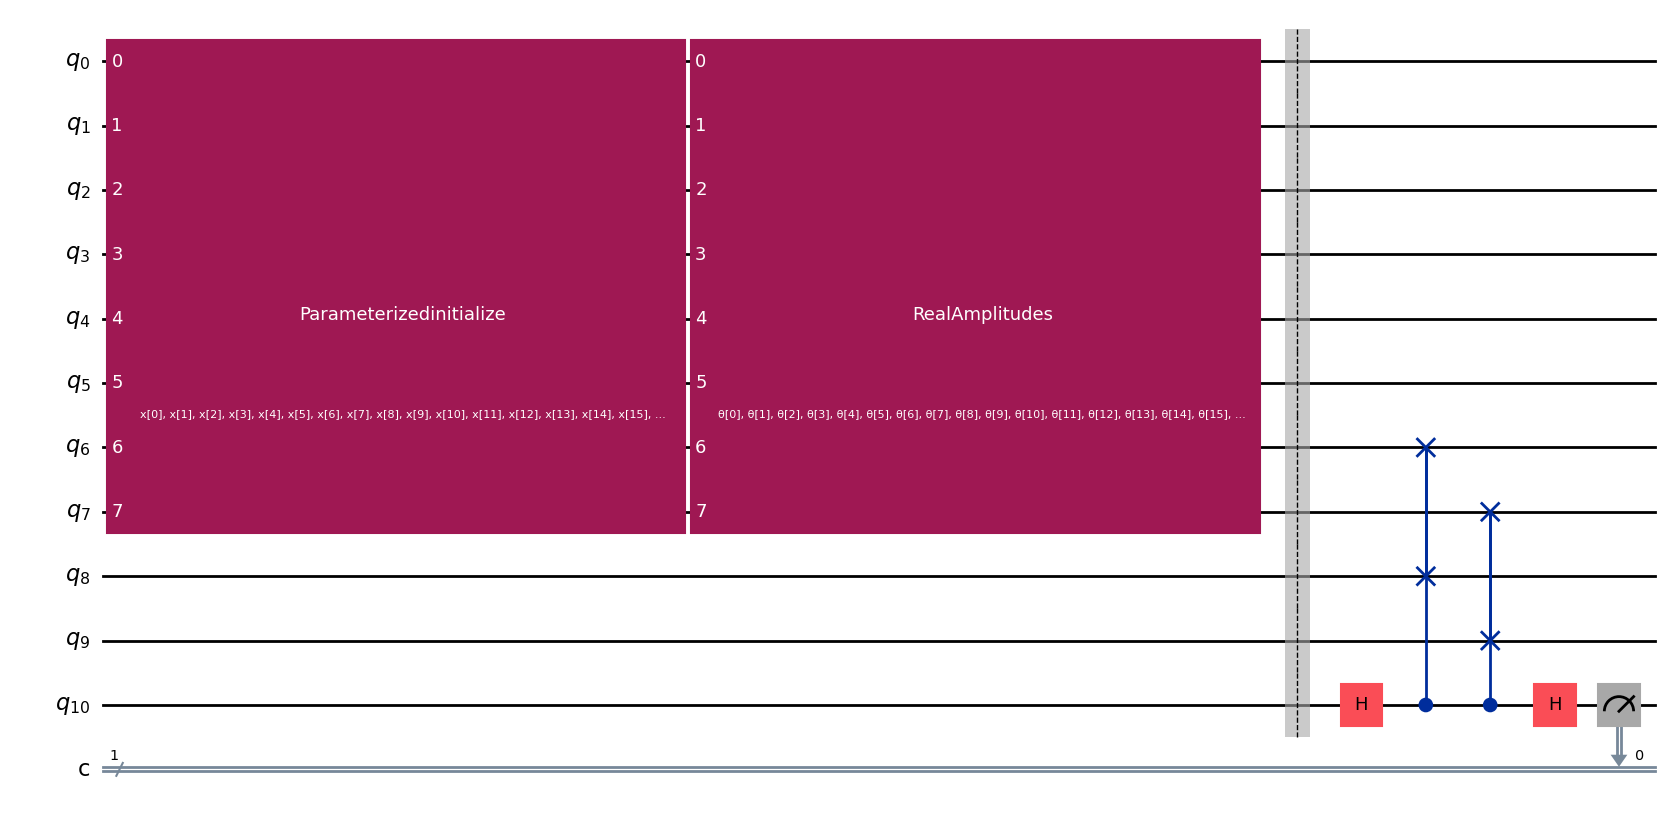

In [6]:
num_latent = 6
num_trash = 2

assert num_latent + num_trash == log2(one_dim), "The number of qubits in the latent space and the trash space must be equal to the log2 of the dimension of the input data"

fm = RawFeatureVector(2 ** (num_latent + num_trash))

ae = auto_encoder_circuit(num_latent, num_trash)

qc = QuantumCircuit(num_latent + 2 * num_trash + 1, 1)
qc = qc.compose(fm, range(num_latent + num_trash))
qc = qc.compose(ae)

qc.draw(output="mpl", style="iqp")

In [7]:
def identity_interpret(x):
    return x


qnn = SamplerQNN(
    circuit=qc,
    input_params=fm.parameters,
    weight_params=ae.parameters,
    interpret=identity_interpret,
    output_shape=num_of_digits,
)

In [8]:
objective_func_vals = []
def cost_func_digits(params_values):
    probabilities = qnn.forward(new_images, params_values)
    cost = np.sum(probabilities[:, 1]) / new_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost

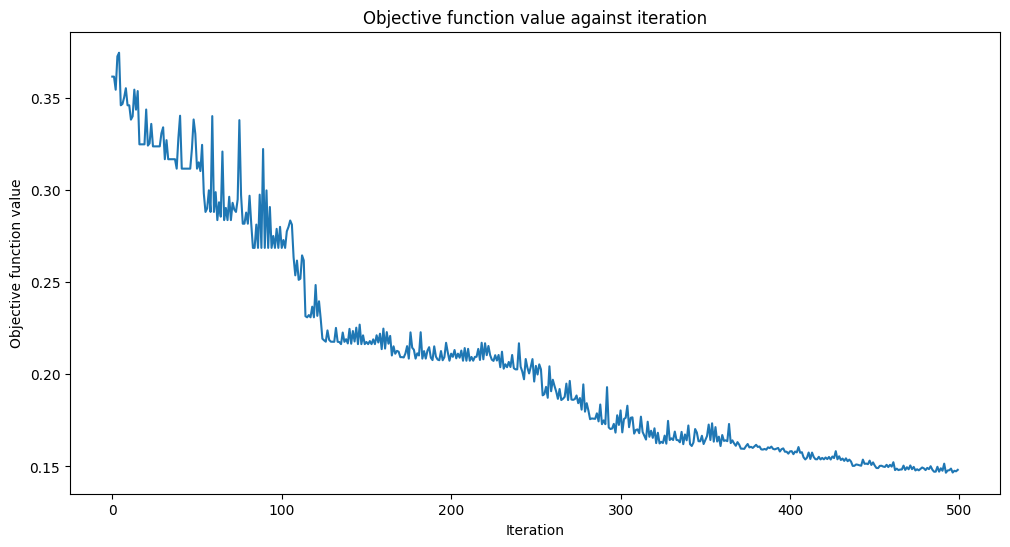

Fit in 3283.14 seconds


In [9]:
objective_func_vals = []
opt = COBYLA(maxiter=500)
initial_point = algorithm_globals.random.random(ae.num_parameters)

# make the plot nicer
plt.rcParams["figure.figsize"] = (12, 6)

start = time.time()
opt_result = opt.minimize(fun=cost_func_digits, x0=initial_point)
elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} seconds")

In [10]:
def decode_image(image):
    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    return np.reshape(np.abs(output_sv) ** 2, new_size) 

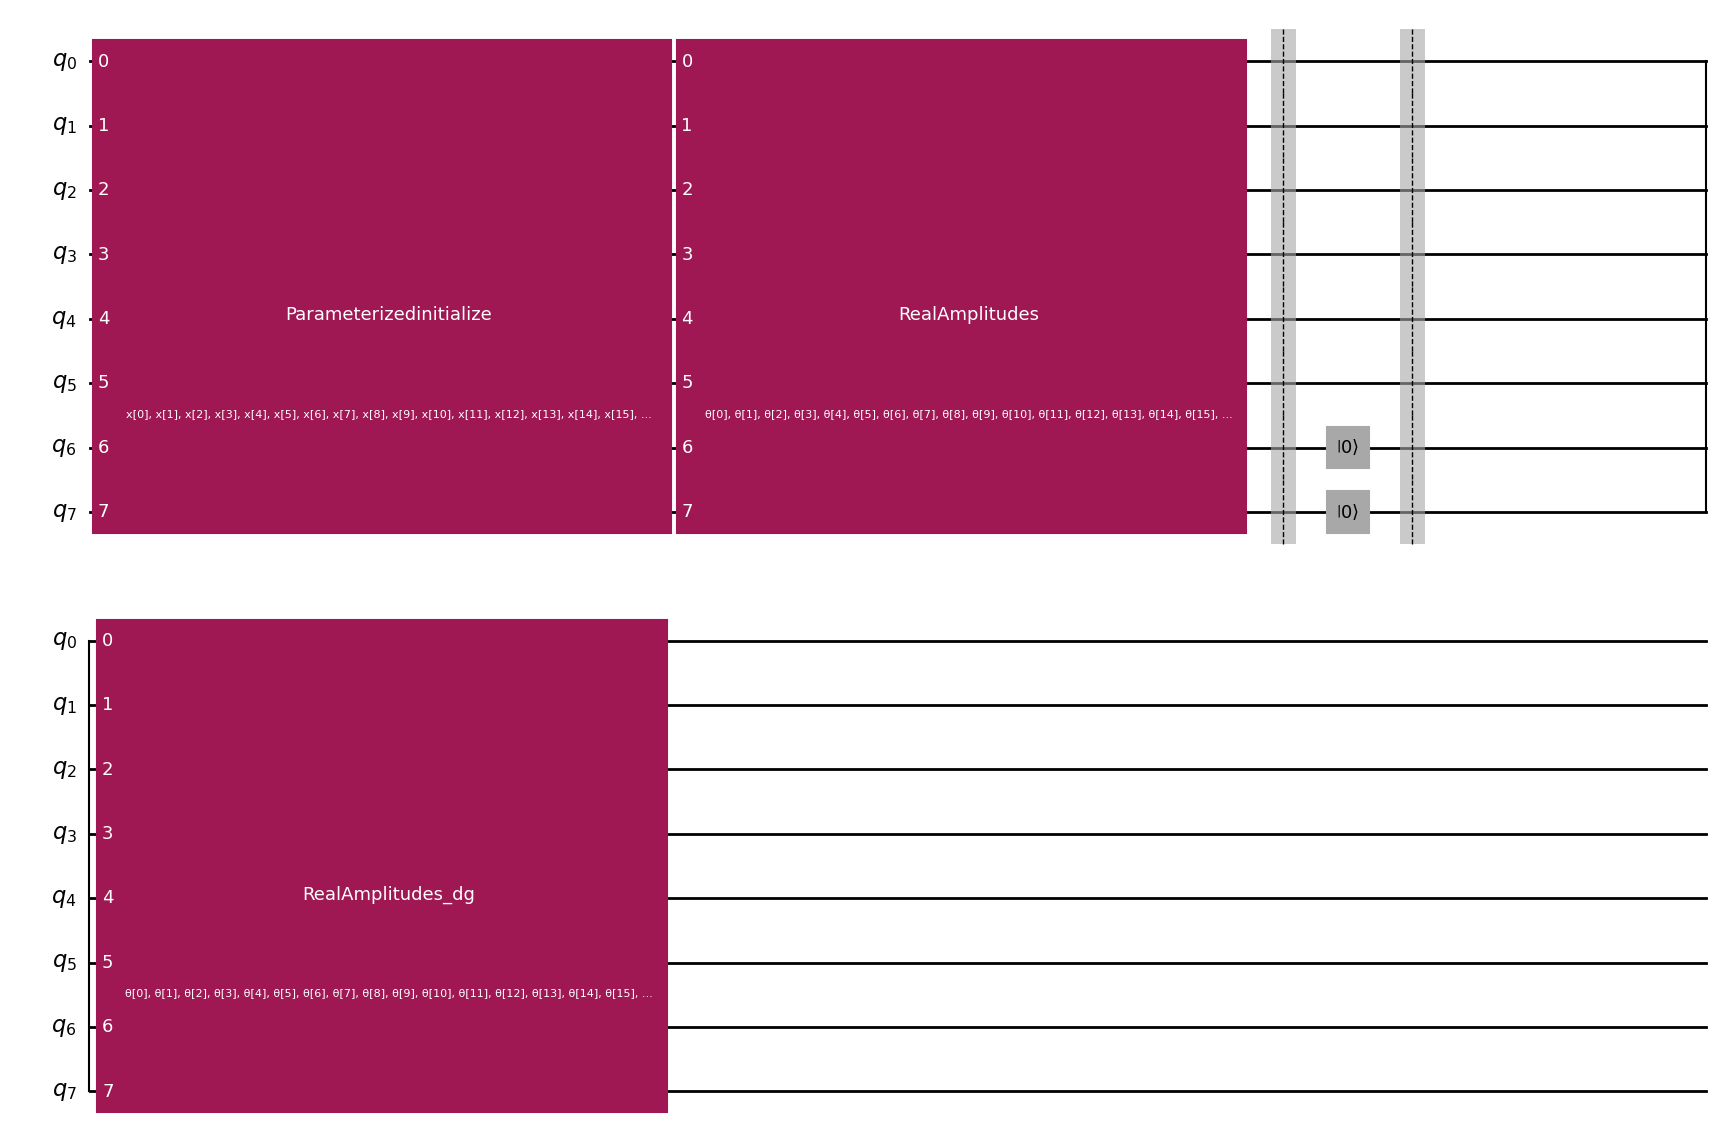

In [64]:
# Test
test_qc = QuantumCircuit(num_latent + num_trash)
test_qc = test_qc.compose(fm)
ansatz_qc = ansatz(num_latent + num_trash)
test_qc = test_qc.compose(ansatz_qc)
test_qc.barrier()
test_qc.reset(7)
test_qc.reset(6)
test_qc.barrier()
test_qc = test_qc.compose(ansatz_qc.inverse())
test_qc.draw(output="mpl", style="iqp")

In [12]:
def calculate_fidelity(sv1: np.ndarray, sv2: np.ndarray) -> float:
    return np.sqrt(np.dot(sv1.flatten().conj(), sv2.flatten()) ** 2)

In [13]:
sum_per_digit = [0 for _ in range(num_of_digits)]

for image, label in zip(new_images, new_labels.flatten()):
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, new_size)

    param_values = np.concatenate((image, opt_result.x))
    output_qc = test_qc.assign_parameters(param_values)
    output_sv = Statevector(output_qc).data
    output_sv = np.reshape(np.abs(output_sv) ** 2, new_size)
    
    fidelity = calculate_fidelity(original_sv, output_sv)
    sum_per_digit[label] += fidelity
    
average_per_digit = [fidelity / num_of_images for fidelity in sum_per_digit]
df = pd.DataFrame(average_per_digit, columns=["Fidelity"])
df

,Fidelity
0,0.013049
1,0.039238
2,0.014199
3,0.012721
4,0.020714
5,0.014748
6,0.015847
7,0.018089
8,0.017185
9,0.022080


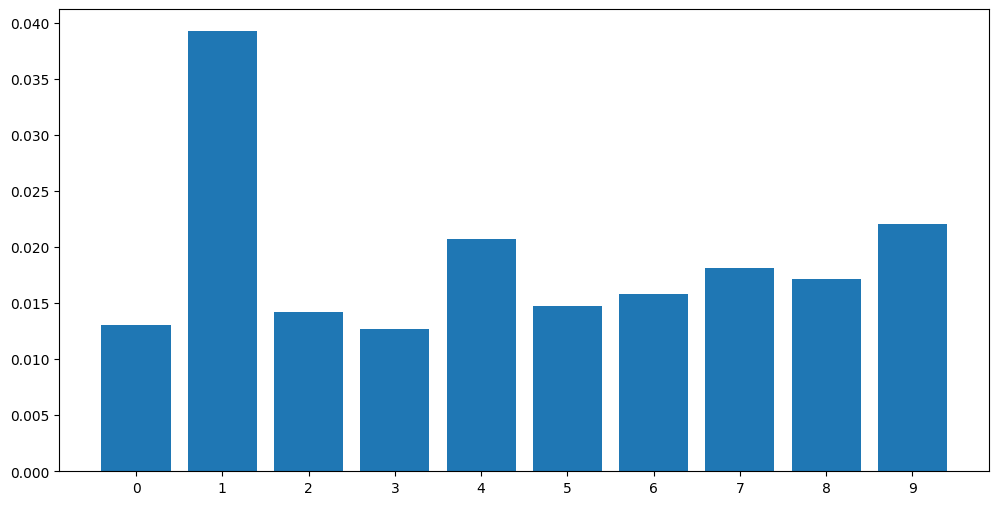

In [14]:
# create a histogram of the fidelities
plt.bar(range(num_of_digits), [fidelity / num_of_images for fidelity in sum_per_digit])
# use the label for the x-axis
plt.xticks(range(num_of_digits), [str(i) for i in range(num_of_digits)])
plt.show()

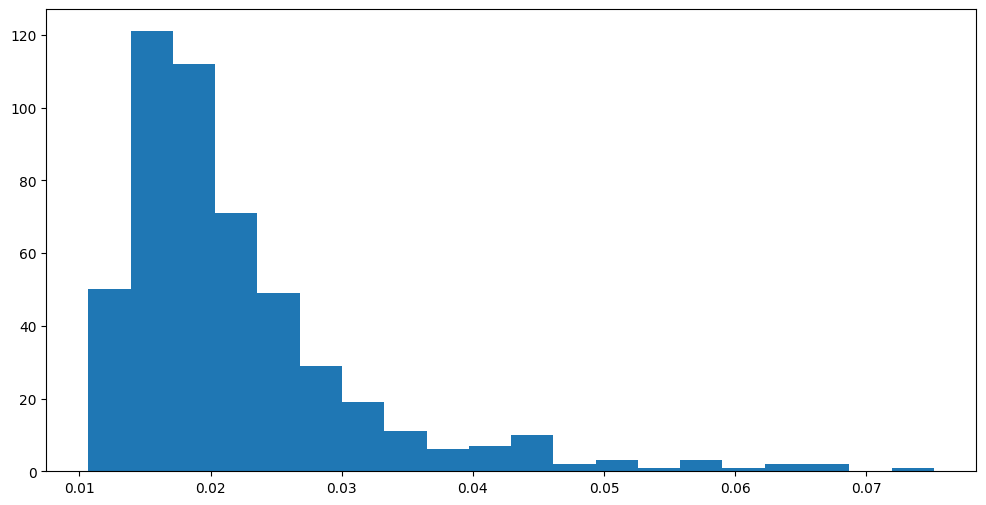

In [45]:
# create a histogram of all individual fidelities
fidelities = []
decoded_images = []
for image in new_images:
    original_qc = fm.assign_parameters(image)
    original_sv = Statevector(original_qc).data
    original_sv = np.reshape(np.abs(original_sv) ** 2, new_size)

    best_fidelity = 0
    best_decoded_image = None
    shots = 100
    while best_fidelity < 0.015 and shots > 0:
        output_sv = decode_image(image)
        fidelity = calculate_fidelity(original_sv, output_sv)
        if fidelity > best_fidelity:
            best_fidelity = fidelity
            best_decoded_image = output_sv
        shots -= 1
    fidelities.append(best_fidelity)
    decoded_images.append(best_decoded_image)
    
plt.hist(fidelities, bins=20)
plt.show()

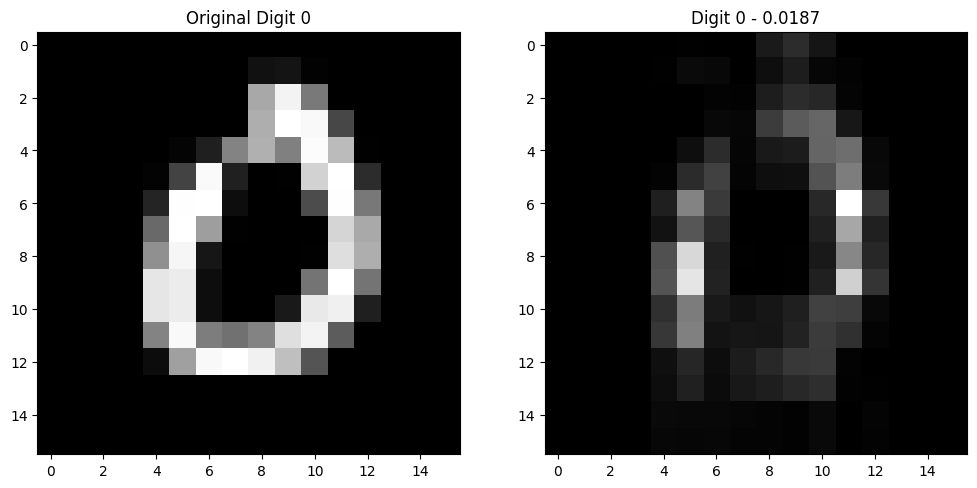

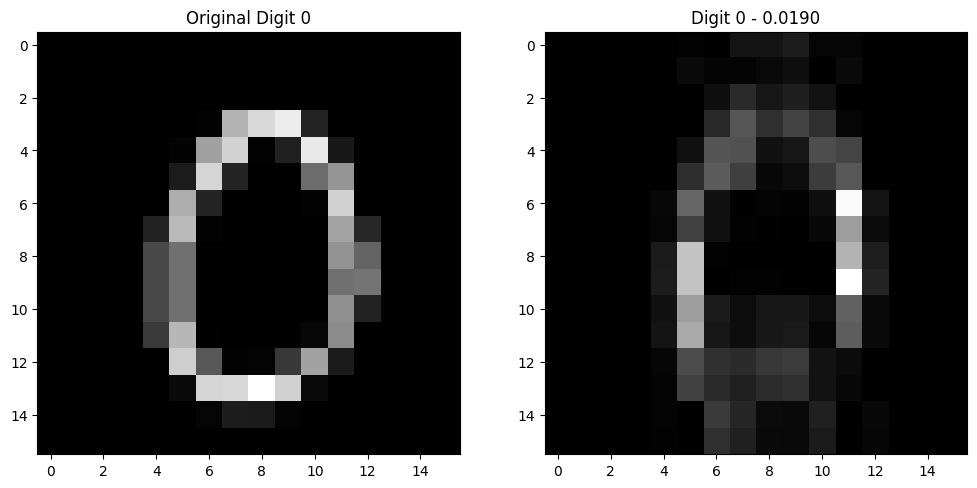

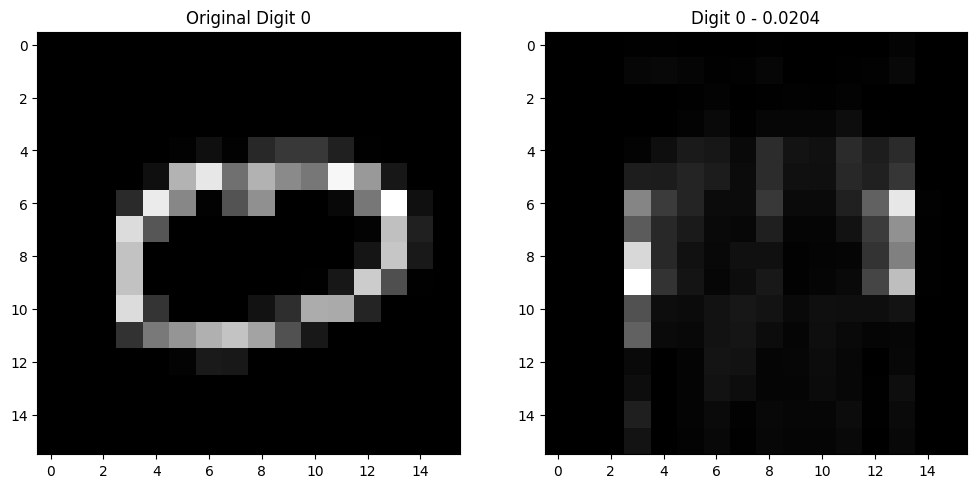

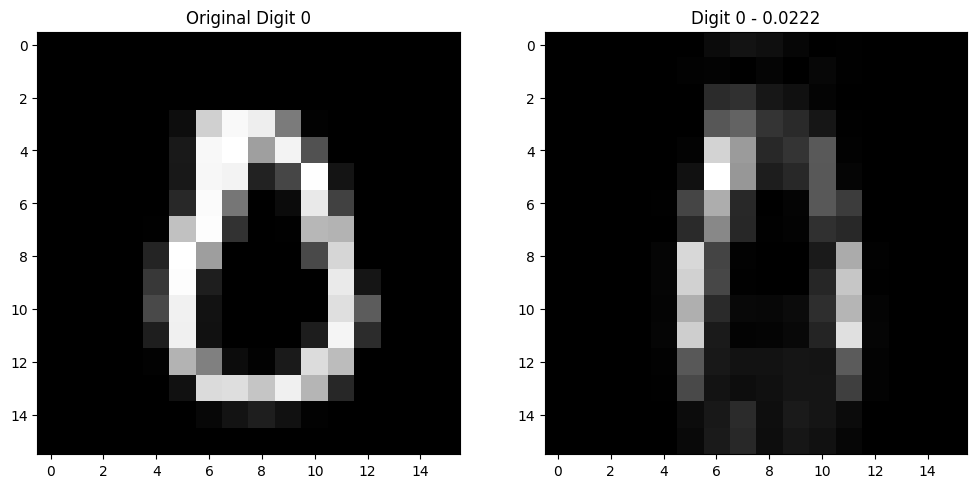

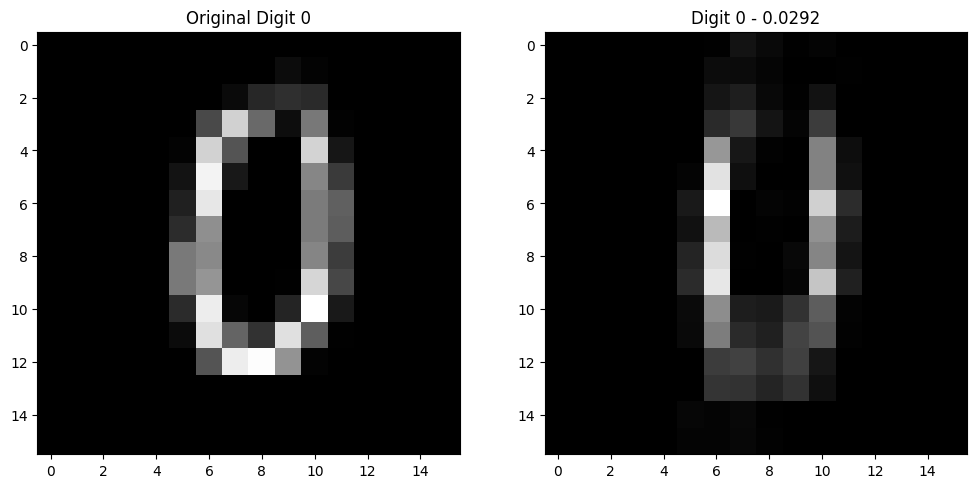

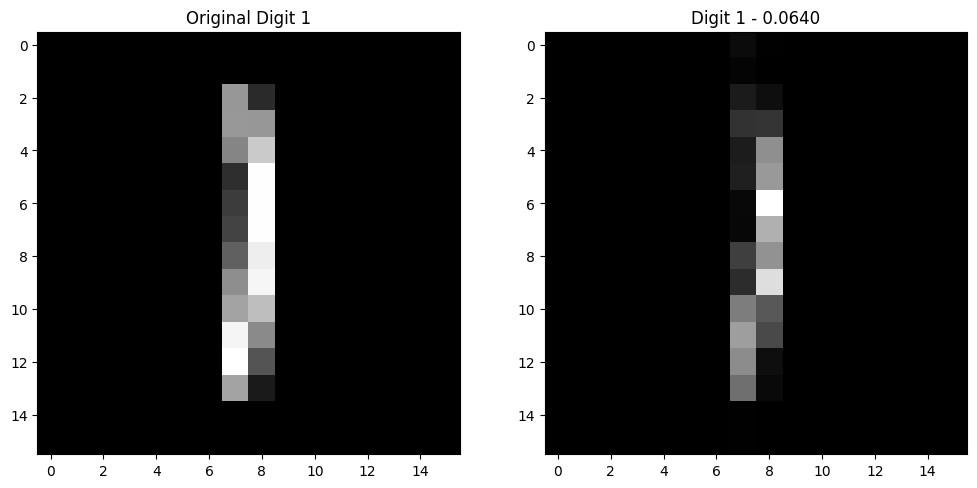

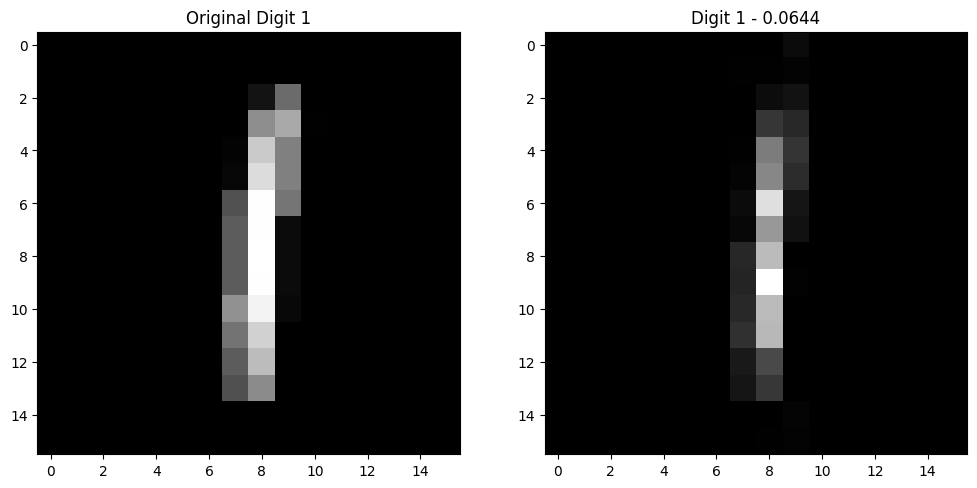

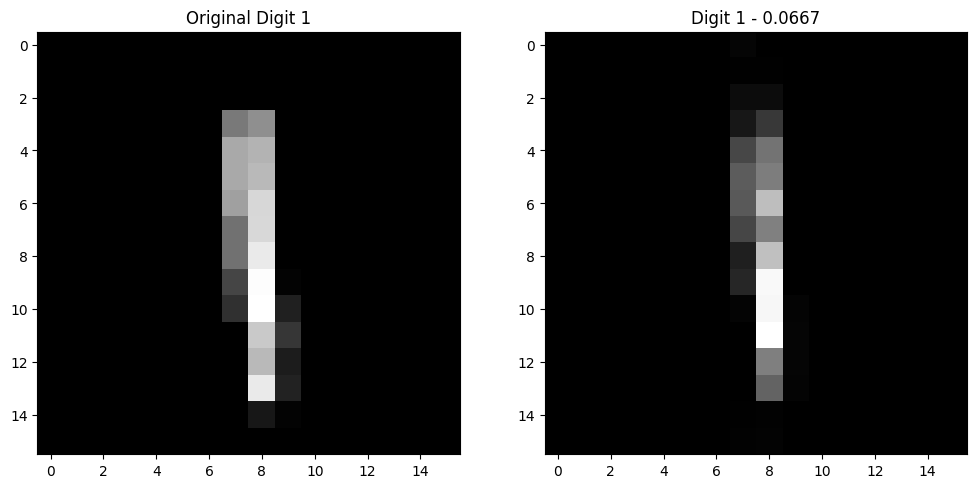

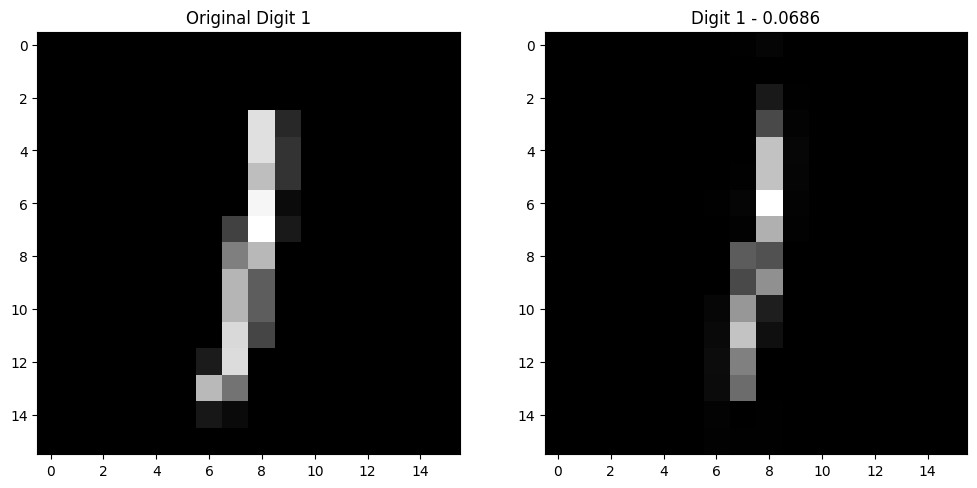

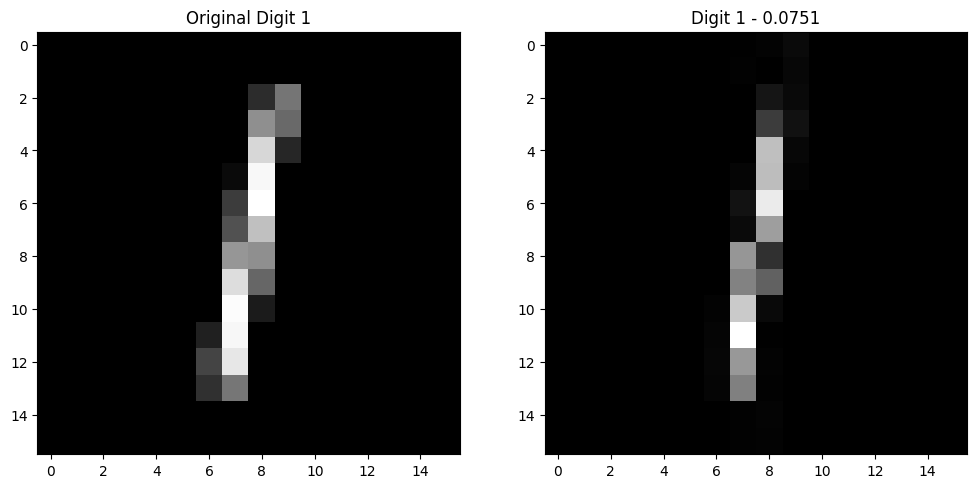

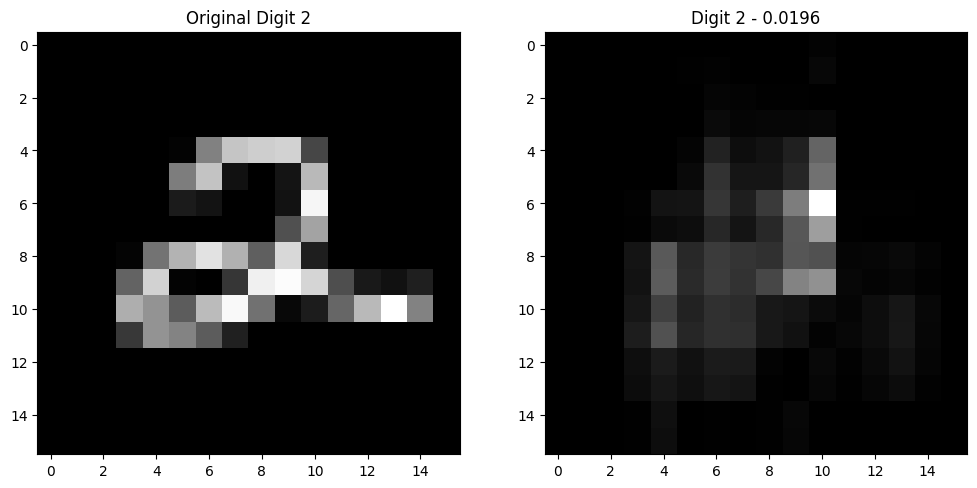

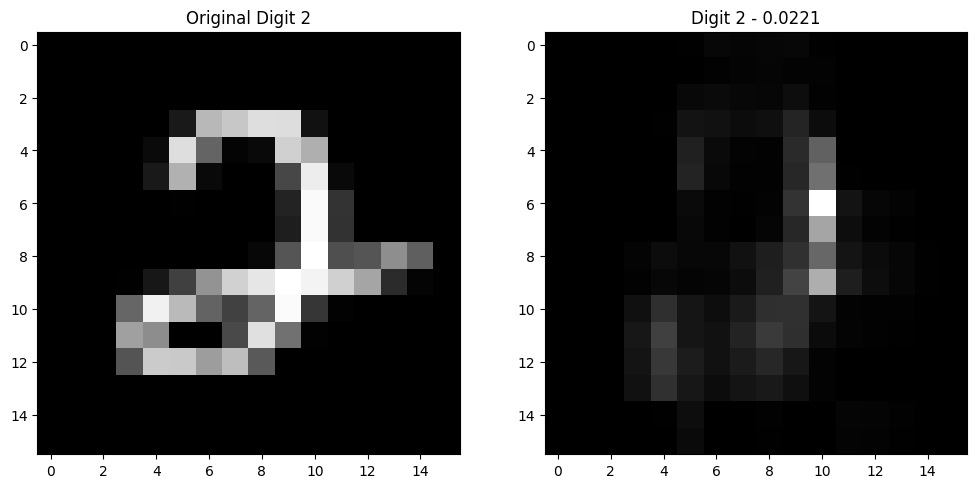

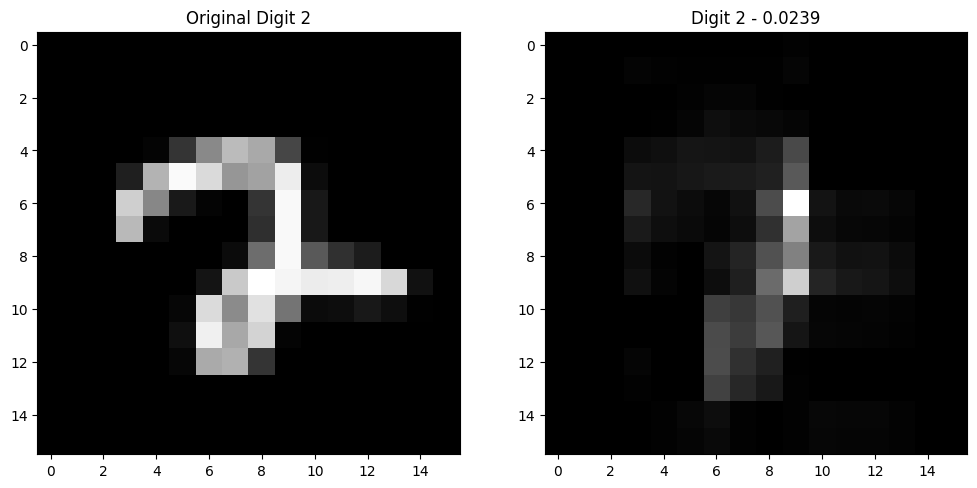

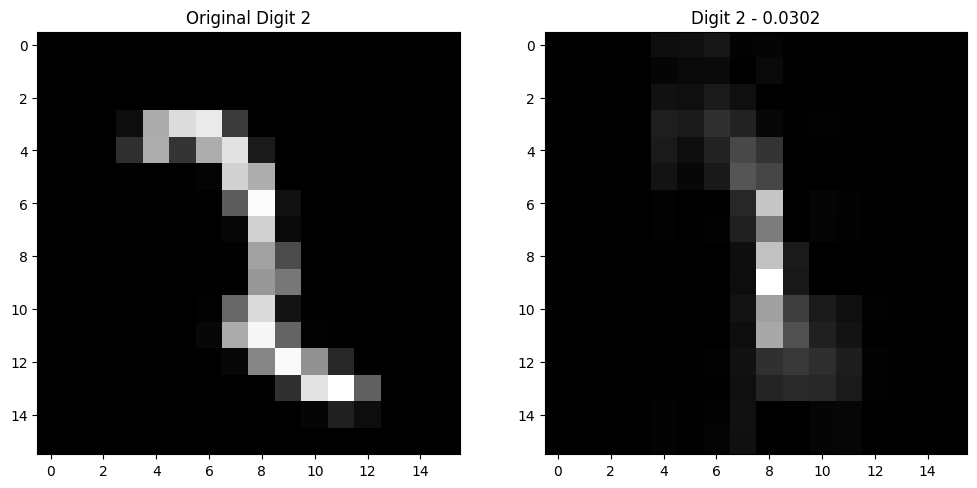

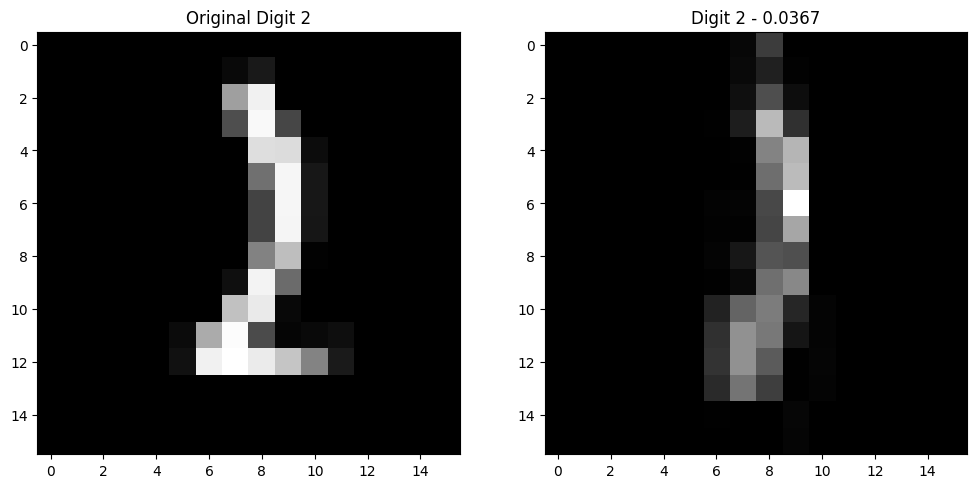

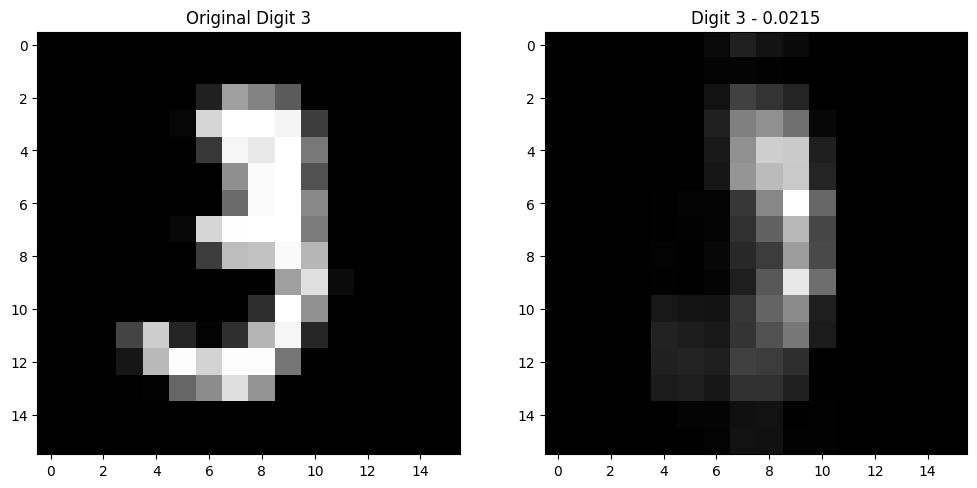

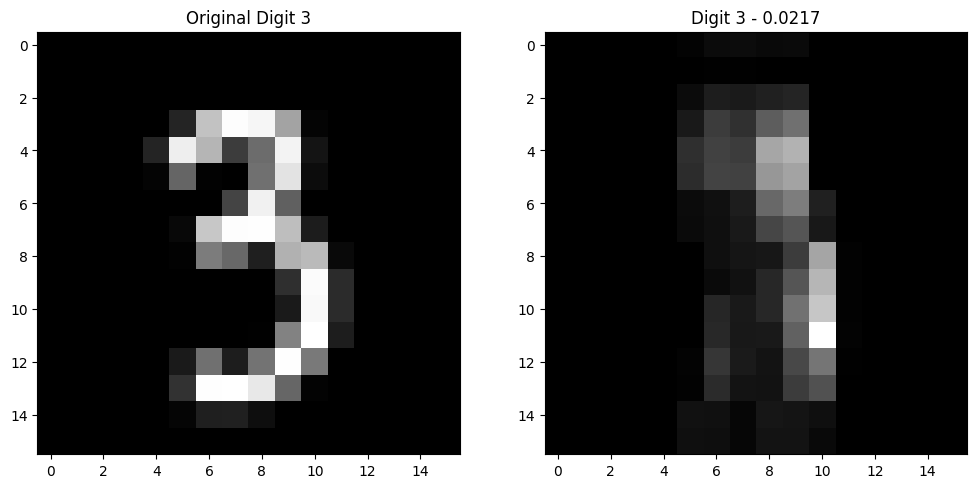

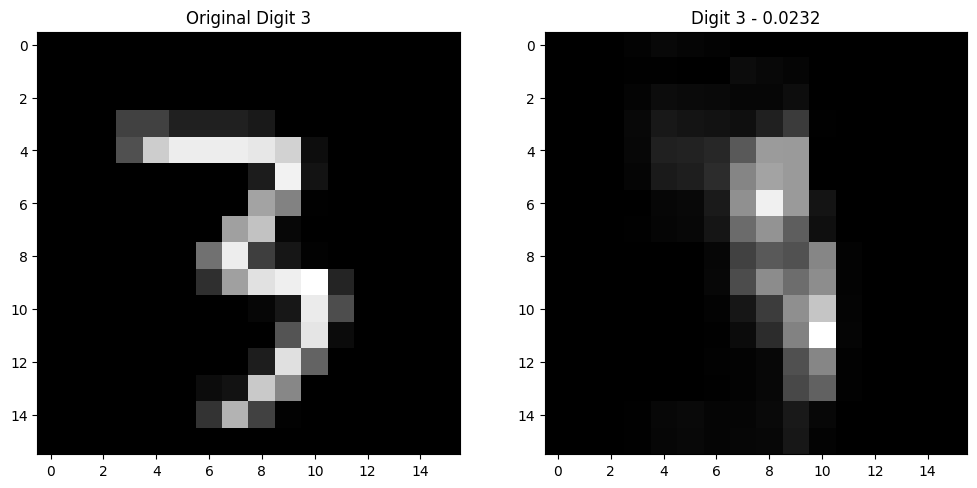

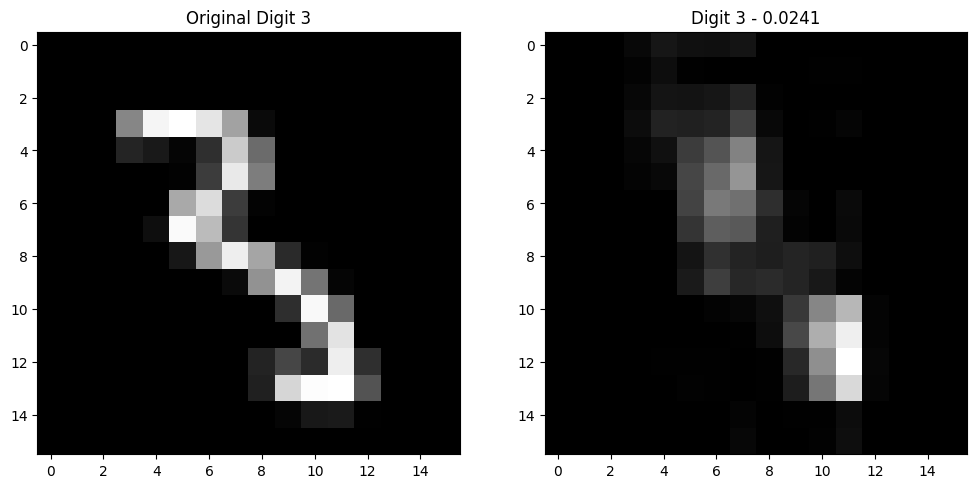

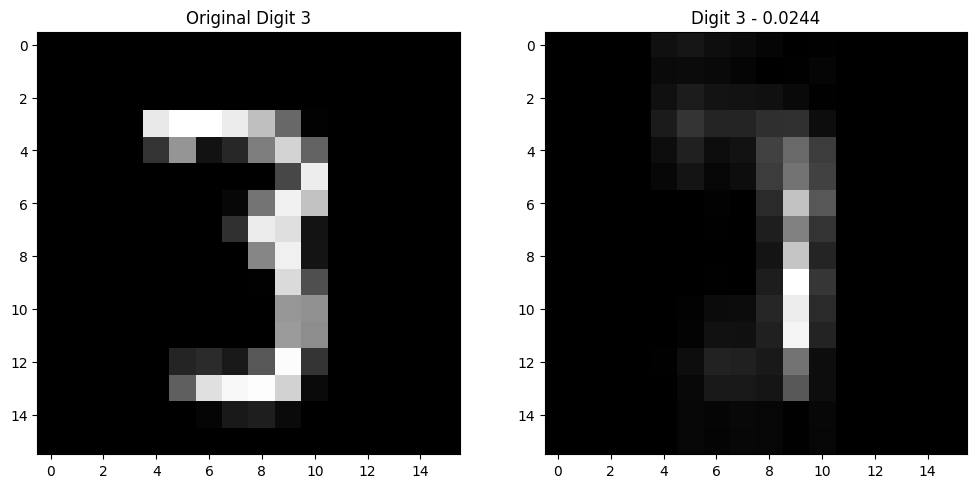

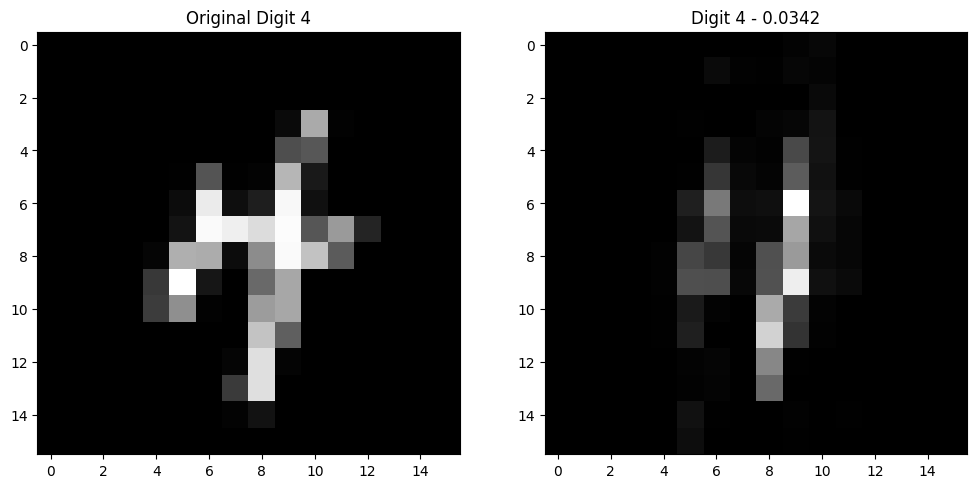

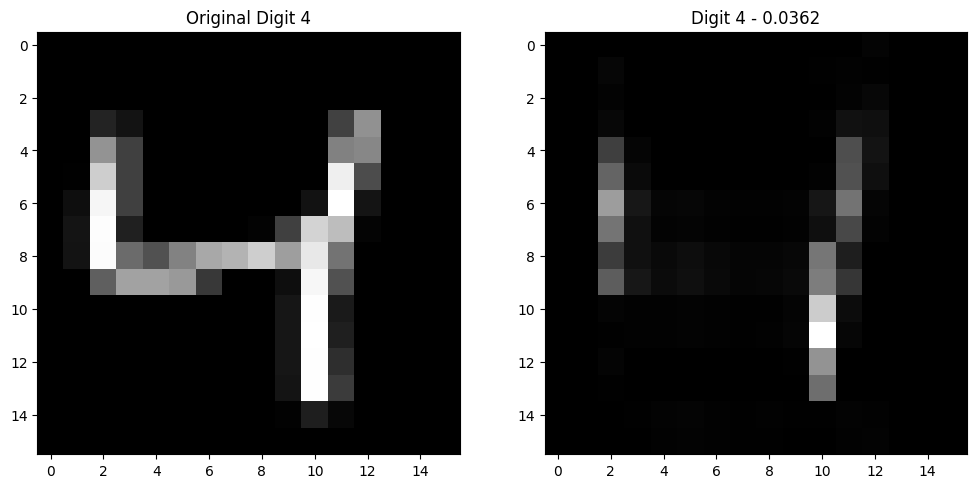

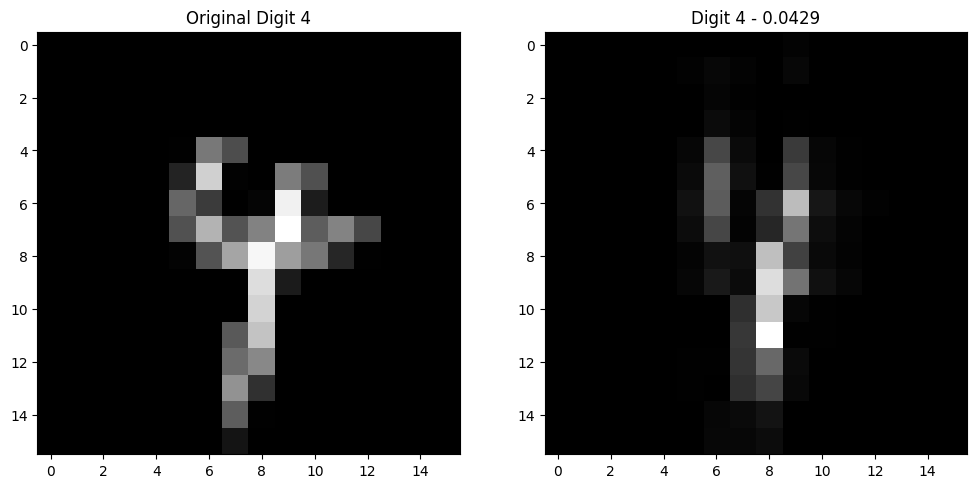

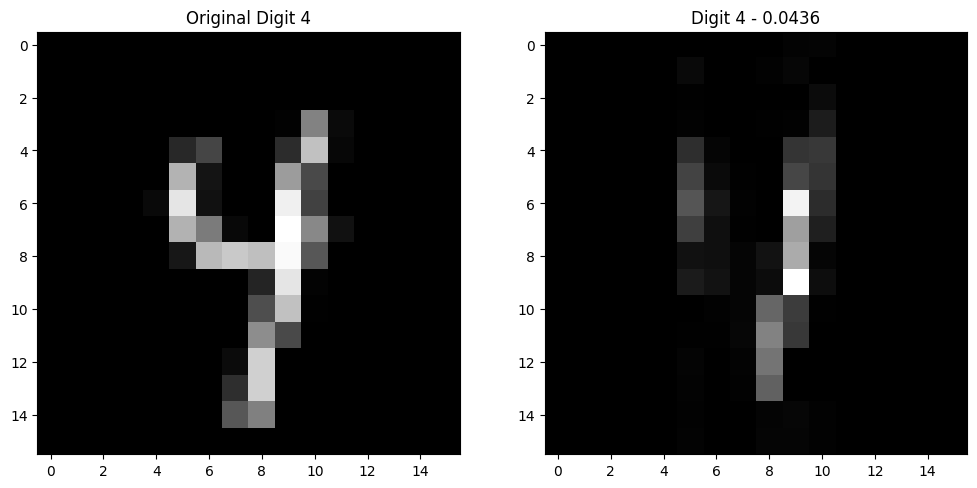

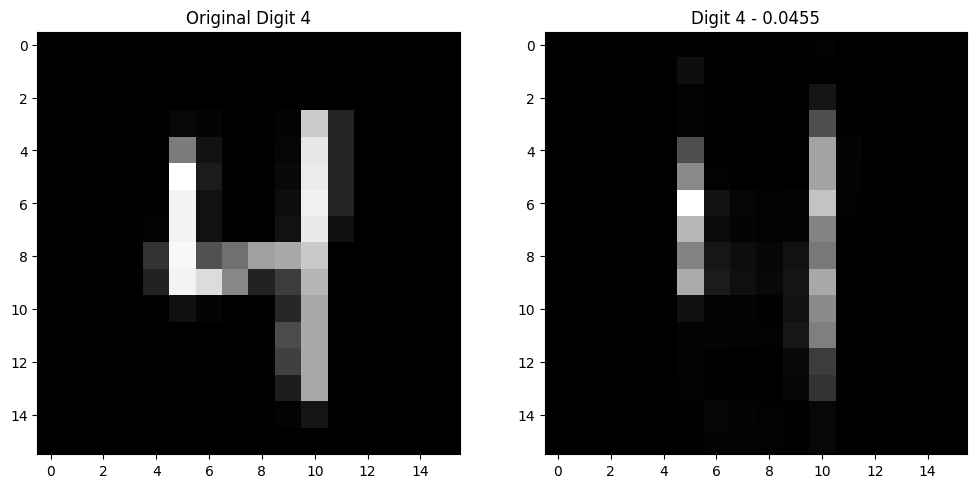

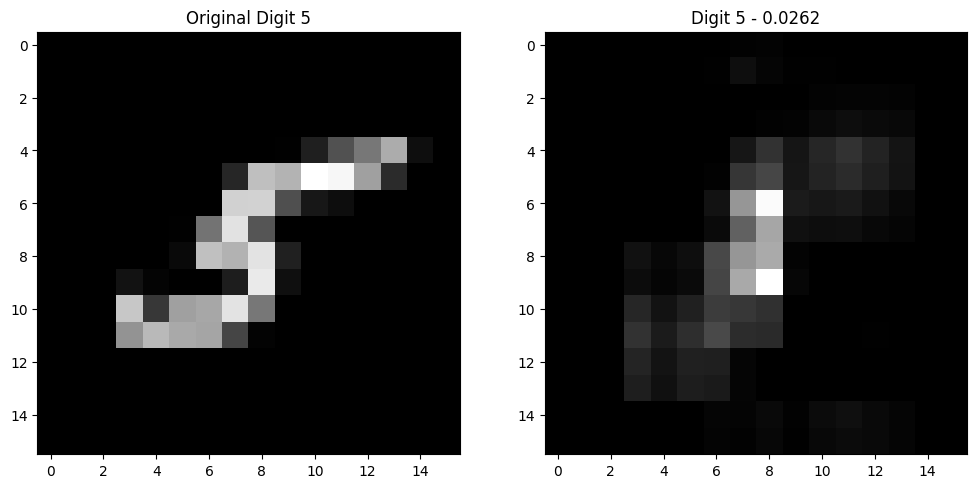

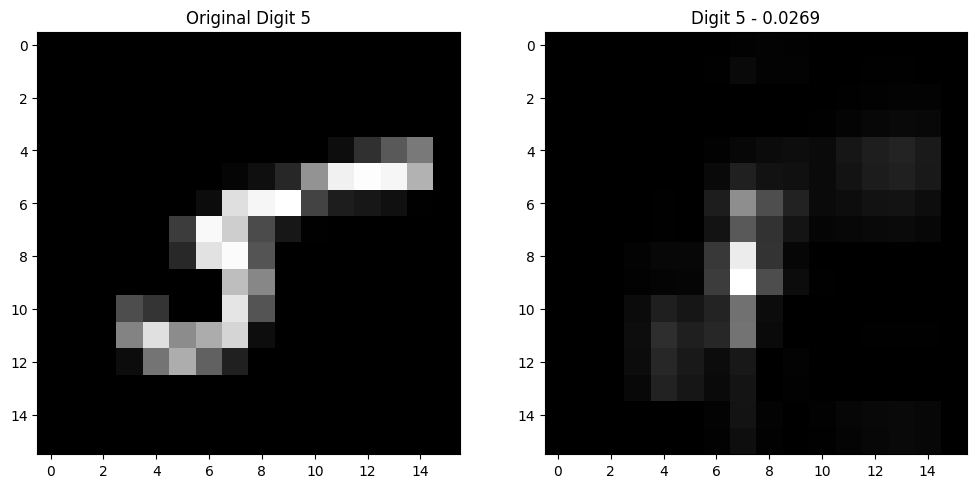

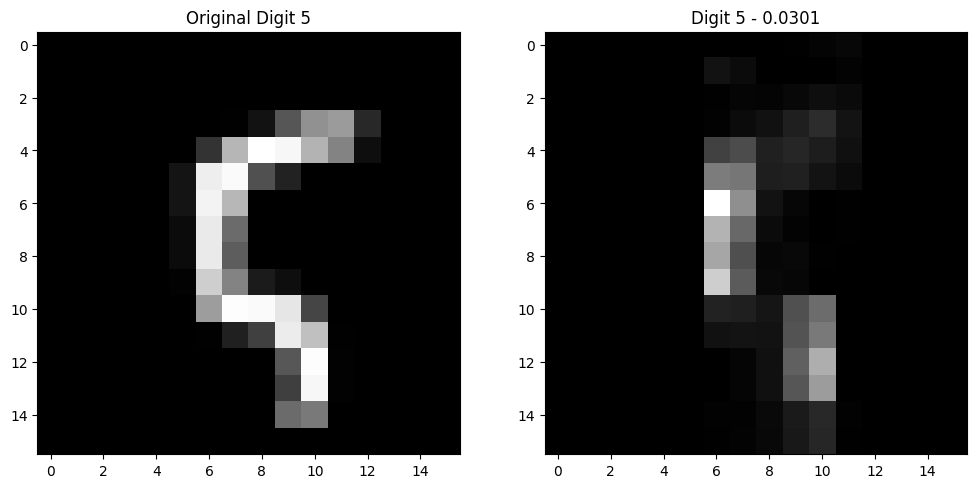

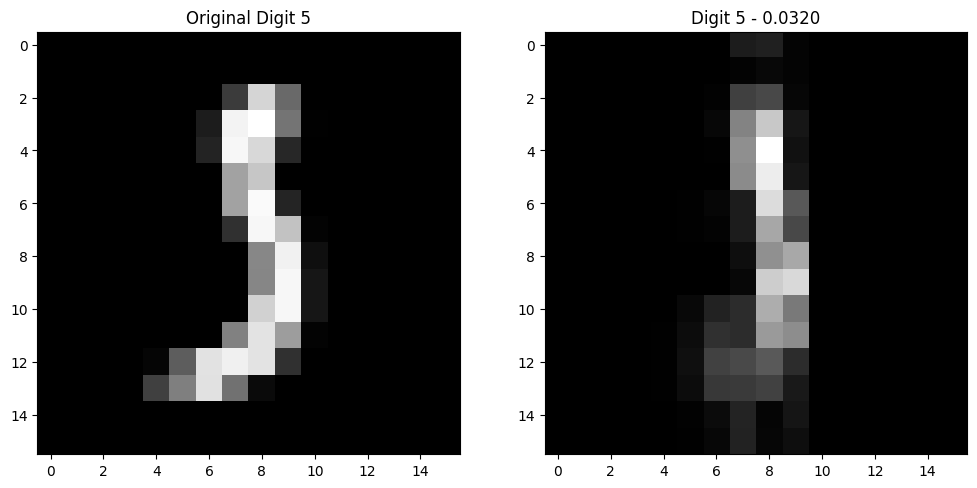

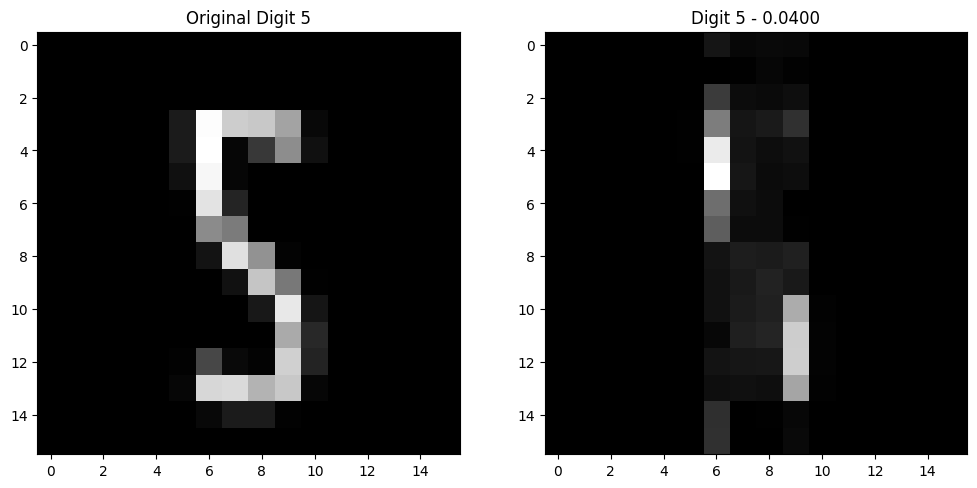

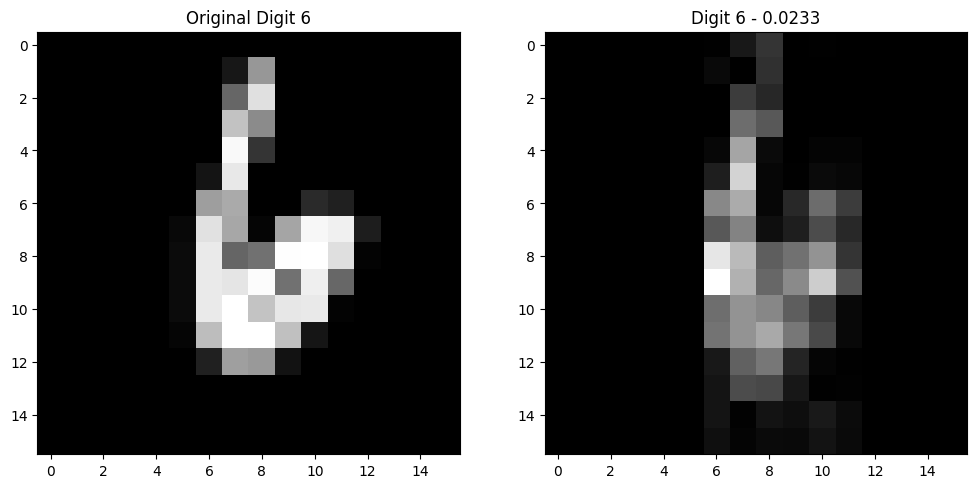

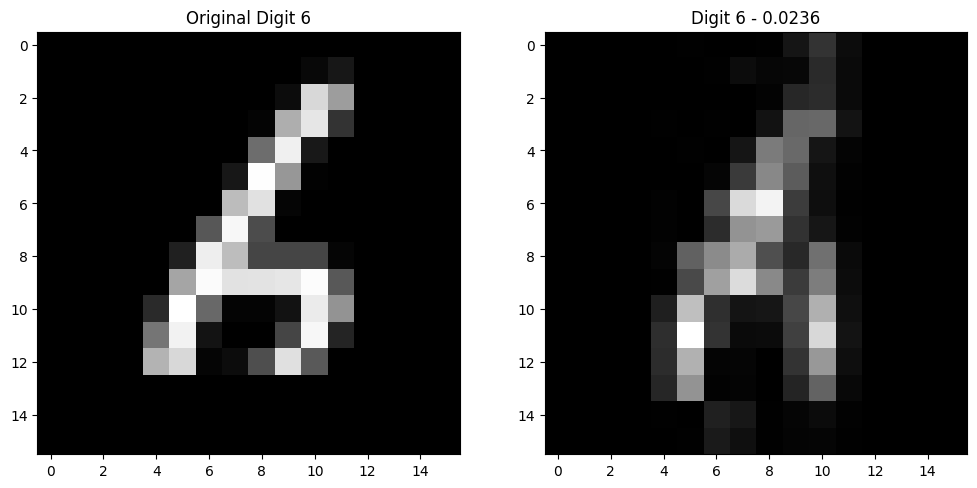

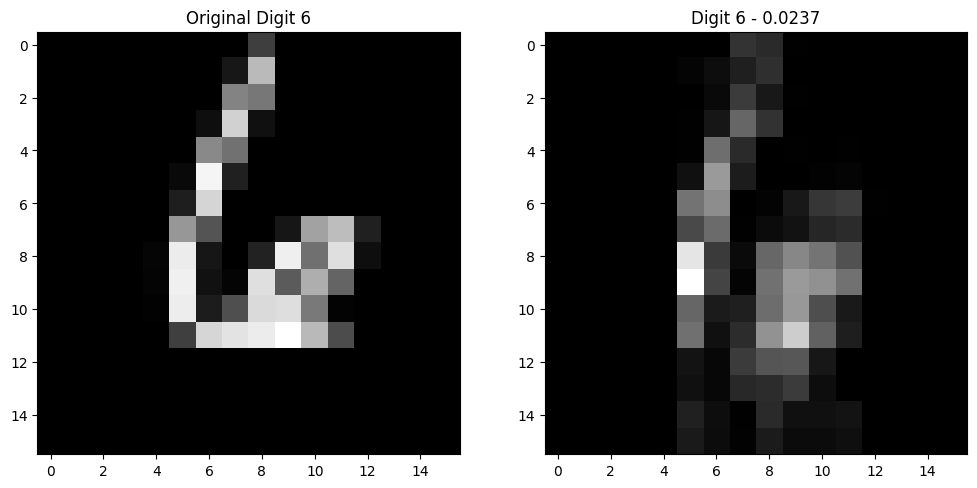

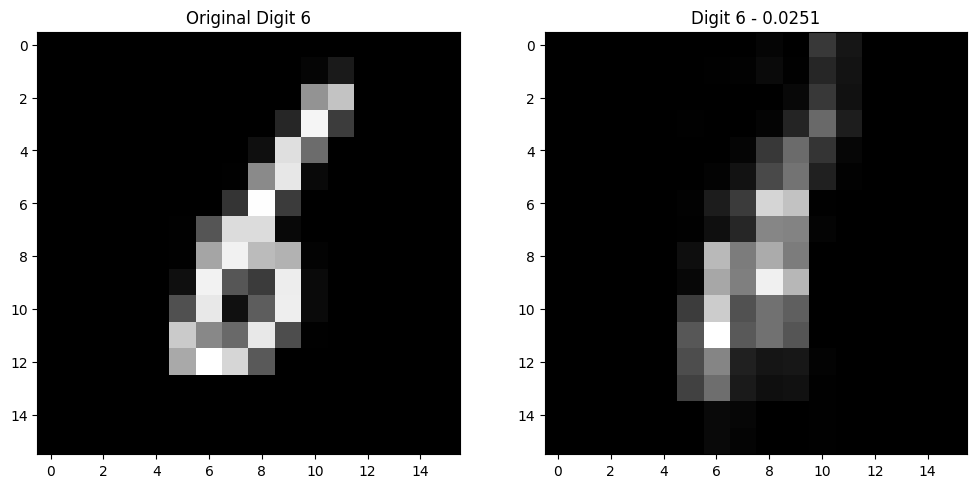

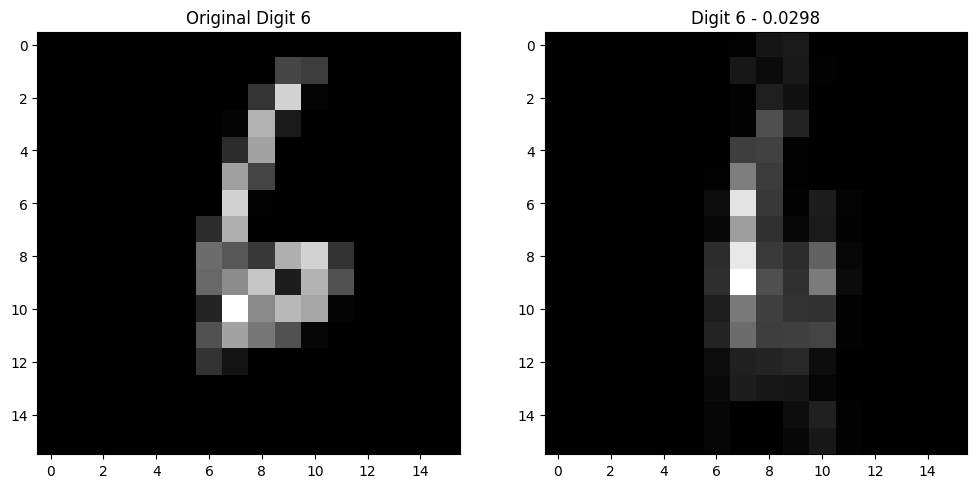

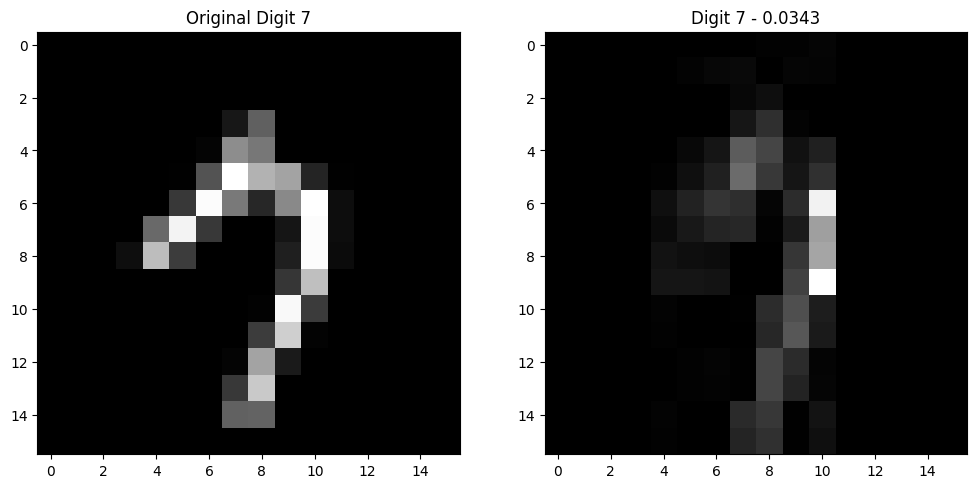

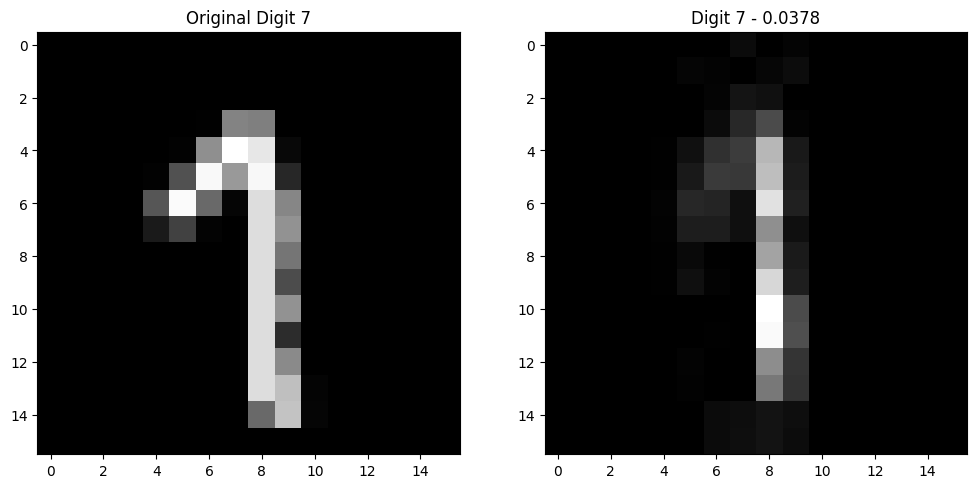

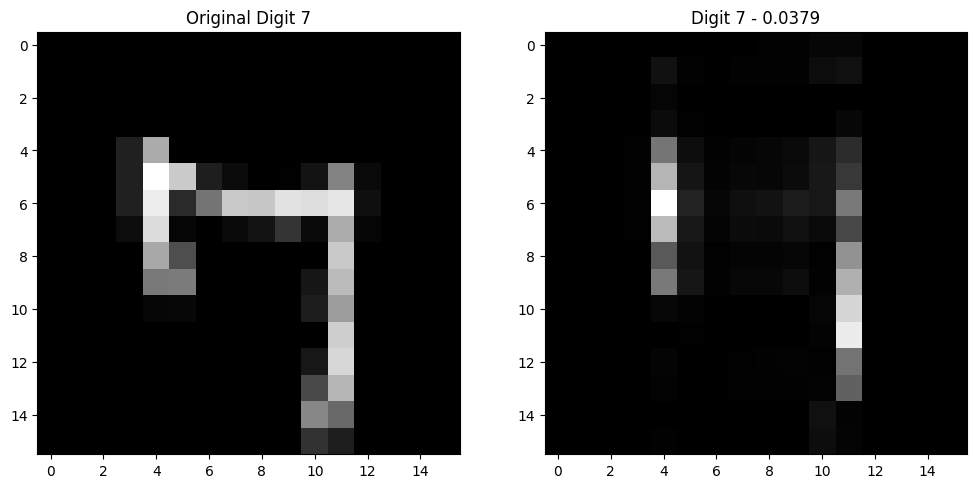

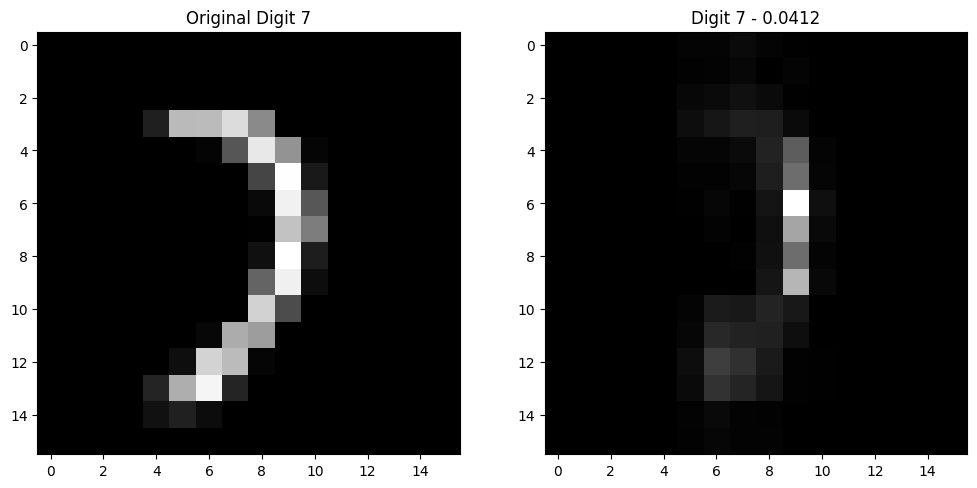

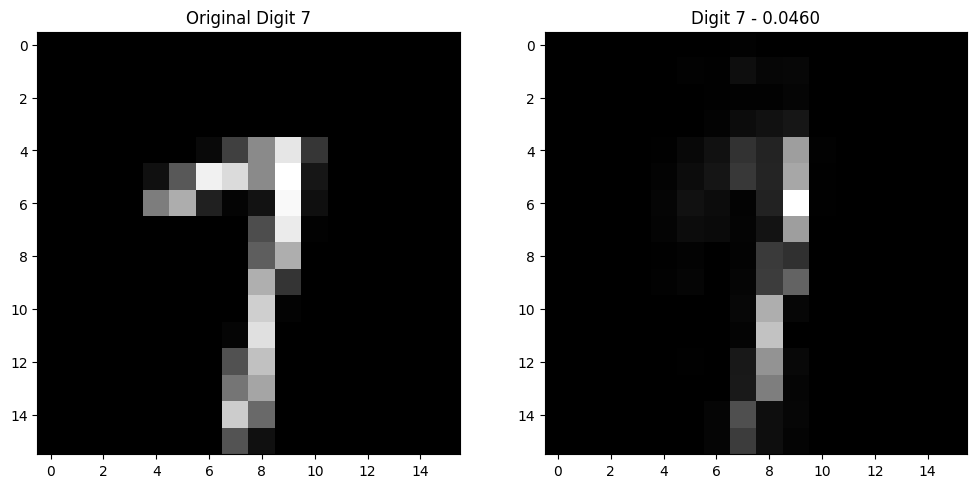

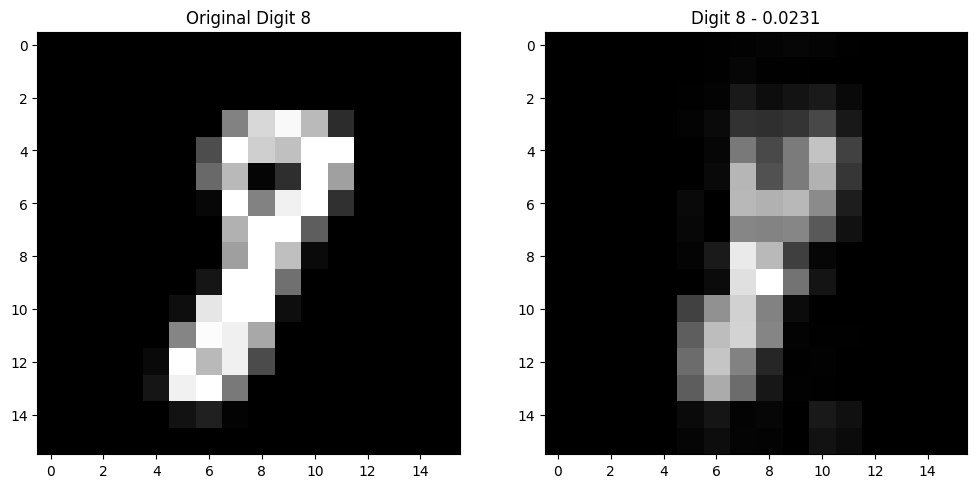

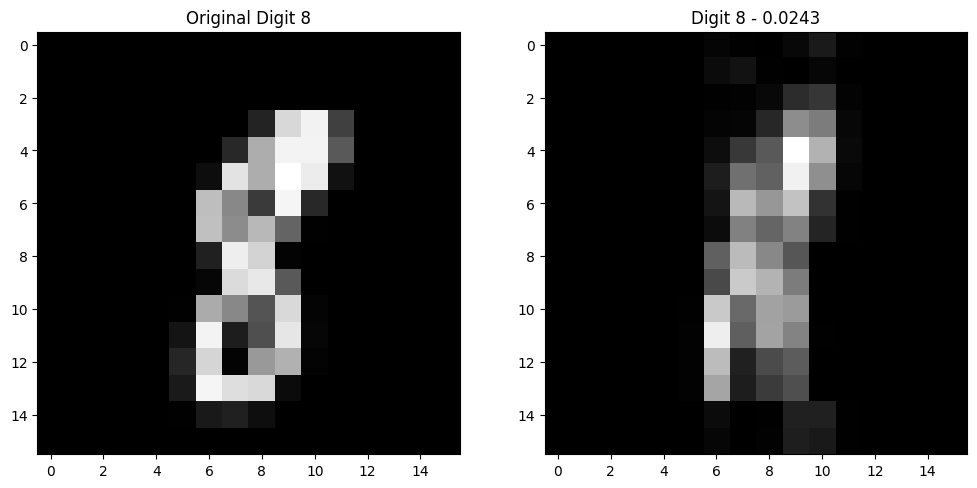

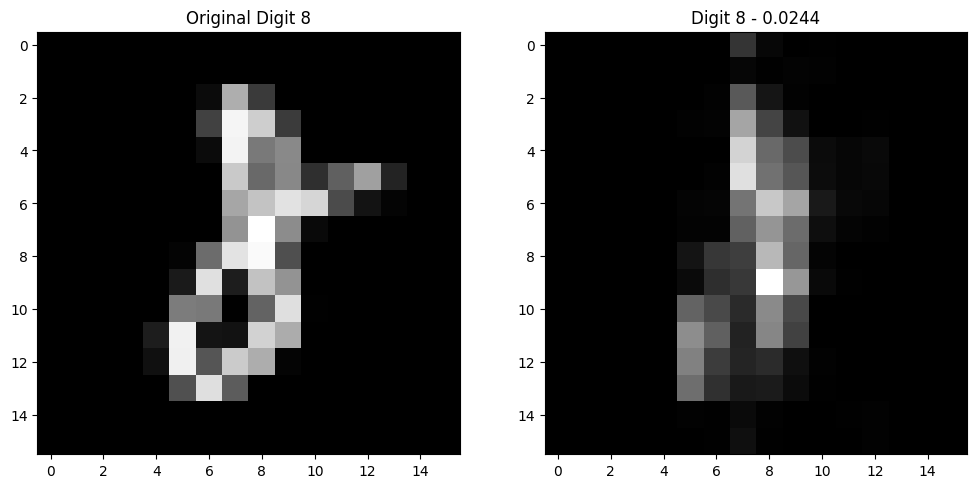

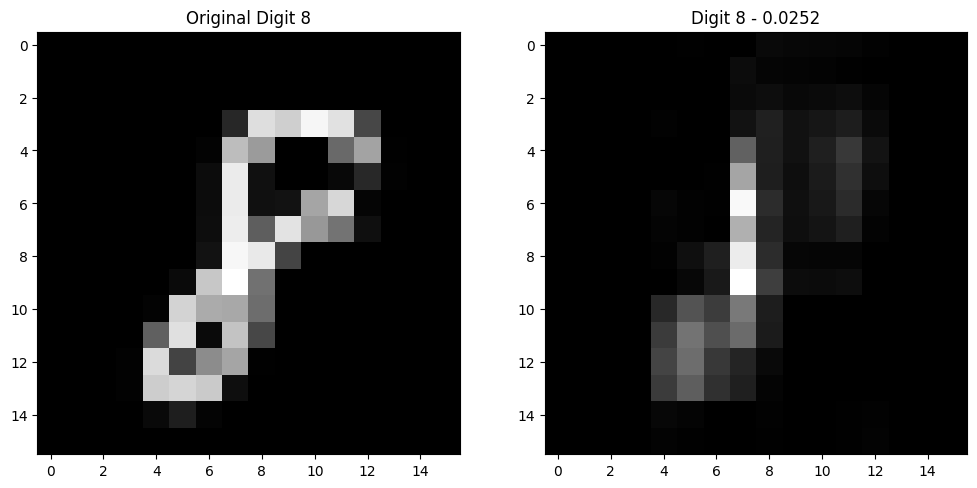

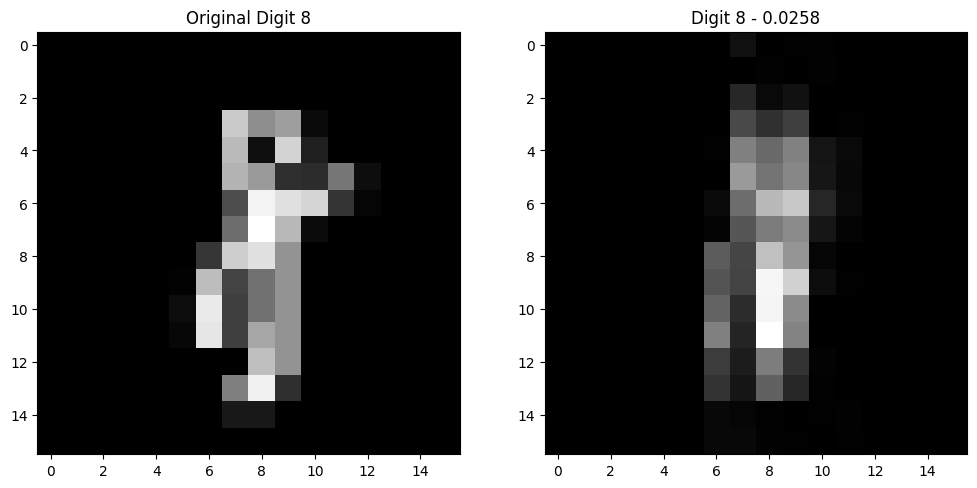

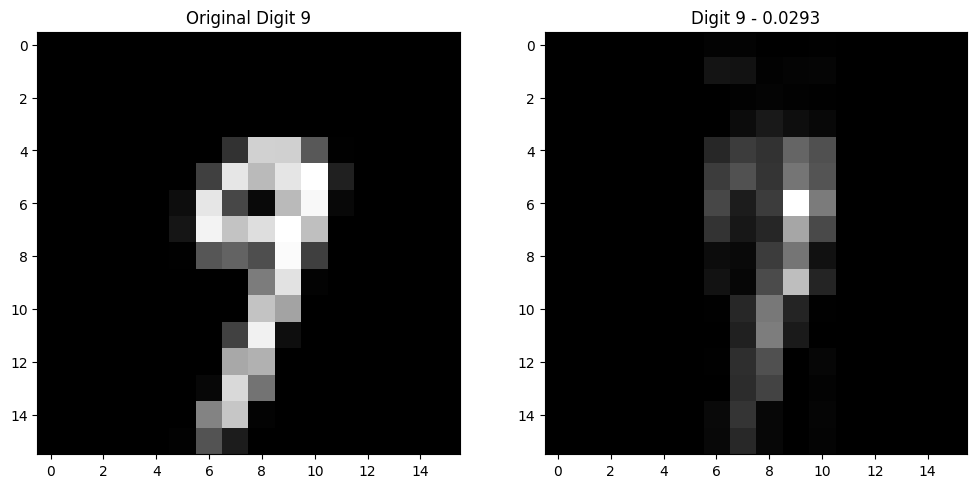

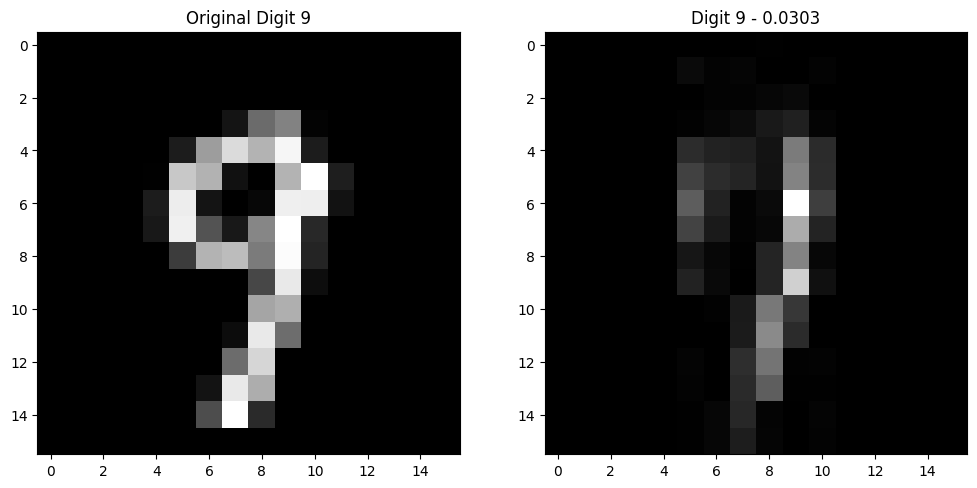

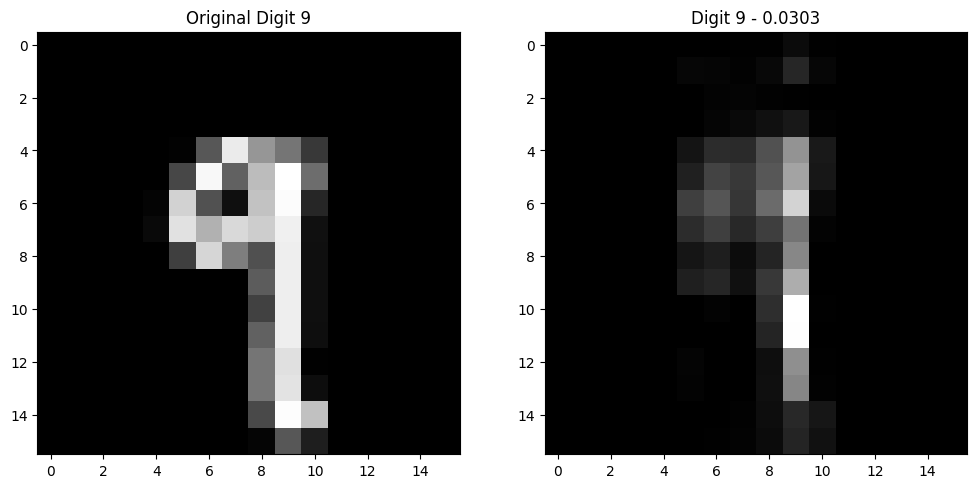

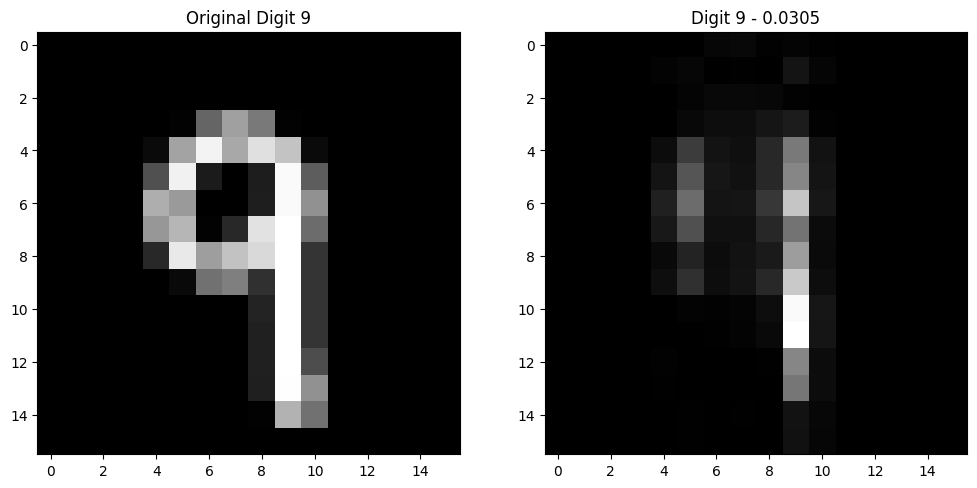

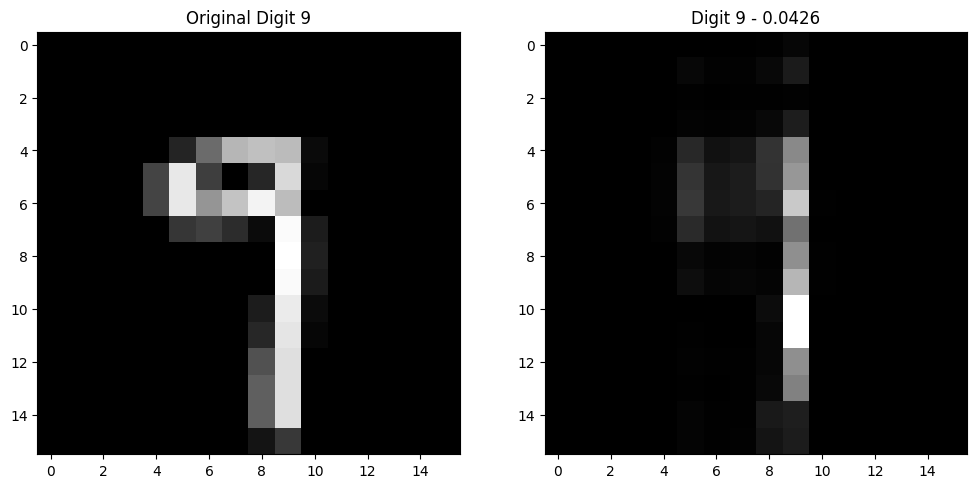

In [84]:
# split the decoded images into the different digits
digit_images = np.array(decoded_images)
digit_images = digit_images.reshape(num_of_digits, num_of_images, new_size[0], new_size[1])
    
# split the original images into the different digits
original_digit_images = np.array(new_images)
original_digit_images = original_digit_images.reshape(num_of_digits, num_of_images, new_size[0], new_size[1])
    
# split the fidelities into the different digits
digits_fidelities = np.array(fidelities)
digits_fidelities = digits_fidelities.reshape(num_of_digits, num_of_images)

# get the indexes of the 5 best fidelities for each digit
# keep track of the indexes as well so i can refer back to the original images
best_fidelities = []
original_images = []
for i in range(num_of_digits):
    indexes = np.argsort(digits_fidelities[i])[-5:]
    best_fidelities.append(indexes)
    original_images.append([original_digit_images[i][j] for j in indexes])

    
# plot the images with the best fidelities
for i in range(num_of_digits):
    for j in range(5):
        fig, (ax1, ax2) = plt.subplots(1, 2)

        ax1.imshow(np.reshape(original_images[i][j], new_size), cmap = "gray")
        ax1.set_title(f"Original Digit {i}")

        ax2.imshow(digit_images[i][best_fidelities[i][j]], cmap = "gray")
        ax2.set_title(f"Digit {i} - {digits_fidelities[i][best_fidelities[i][j]]:.4f}")
        plt.show()

### Showing the images with the highest and lowest fidelities

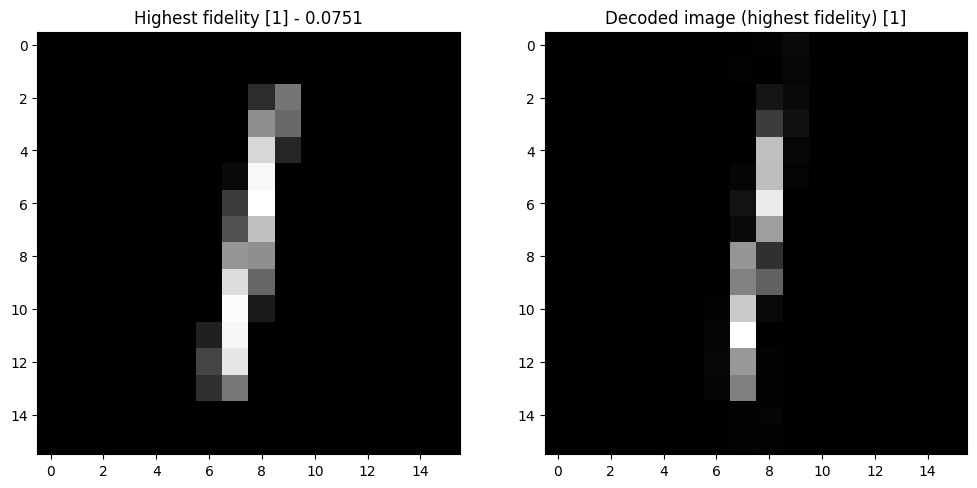

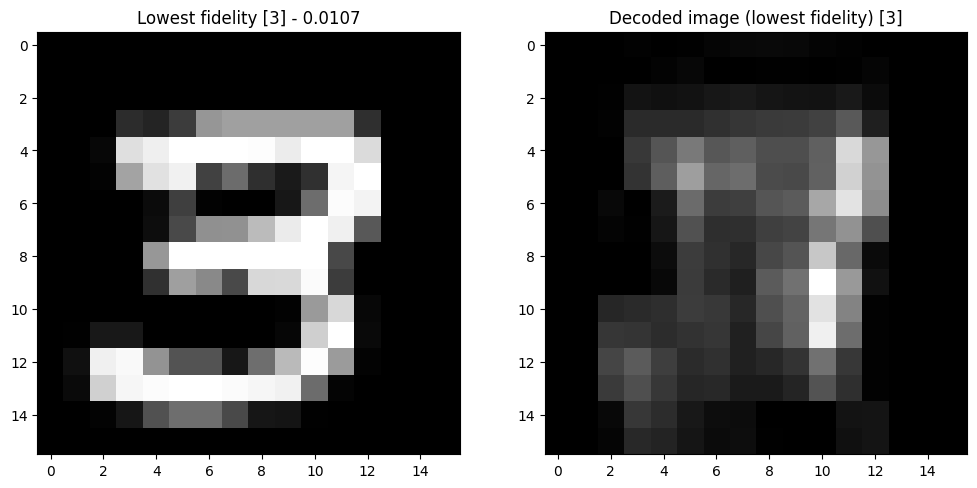

In [46]:
# show images with the highest and lowest fidelities
fidelities = np.array(fidelities)
highest_fidelity = np.argmax(fidelities)
lowest_fidelity = np.argmin(fidelities)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.reshape(new_images[highest_fidelity], new_size), cmap = "gray")
ax1.set_title(f"Highest fidelity {new_labels[highest_fidelity]} - {fidelities[highest_fidelity]:.4f}")

ax2.imshow(decoded_images[highest_fidelity], cmap = "gray")
ax2.set_title(f"Decoded image (highest fidelity) {new_labels[highest_fidelity]}")

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.reshape(new_images[lowest_fidelity], new_size), cmap = "gray")
ax1.set_title(f"Lowest fidelity {new_labels[lowest_fidelity]} - {fidelities[lowest_fidelity]:.4f}")

ax2.imshow(decoded_images[lowest_fidelity], cmap = "gray")
ax2.set_title(f"Decoded image (lowest fidelity) {new_labels[lowest_fidelity]}")
plt.show()

### Showing all images

In [82]:
show_all = False

if show_all:
    for i in range(0, len(decoded_images)):
        image = decoded_images[i]
        original_image = np.reshape(new_images[i], new_size)
        label = new_labels[i]

        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(original_image, cmap = "gray")
        ax1.set_title(f"Input Data {label}")
        ax2.imshow(image, cmap = "gray")
        ax2.set_title(f"Output Data {label} - {fidelities[i]:.4f}")
        plt.show()